Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report,
    make_scorer, r2_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

1 Data Preprocesing

In [11]:
# Load the dataset
df = pd.read_csv("mort_2022-23.csv")
df.head()

def preprocess_dataset(df, scaler_svm=None, scaler_rnn=None, fit_scalers=True):
    """
    Preprocess the mortality dataset:
    - Filters adults (CLAVEEDAD == 5)
    - Handles missing values
    - Scales EDAD
    - Encodes categorical variables
    - Creates binary target column (RENAL_RELATED)
    - Returns EDA and ML-ready datasets

    Parameters:
        df (pd.DataFrame): Raw dataset
        scaler_svm (StandardScaler): Optional scaler for EDAD_SVM
        scaler_rnn (MinMaxScaler): Optional scaler for EDAD_RNN
        fit_scalers (bool): Whether to fit new scalers

    Returns:
        df_cleaned (pd.DataFrame): Cleaned dataset for EDA
        df_ml (pd.DataFrame): Cleaned dataset for ML
        scaler_svm, scaler_rnn: Used scalers
    """
    df = df.copy()

    # Filter to adults
    df = df[df["CLAVEEDAD"] == 5].copy()

    # Define columns
    base_columns = [
        "SEXO", "SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA", "EDAD",
        "ESTADOCONYUGAL", "ESCOLARIDAD", "CLAVEOCUPACIONHABITUAL",
        "TRABAJAACTUALMENTE", "AFILIACION", "MUNICIPIORESIDENCIA",
        "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIA"
    ]
    descripcion_columns = [col for col in df.columns if "DESCRIPCIONCAUSA" in col]
    all_columns = base_columns + descripcion_columns

    df_cleaned = df[all_columns].copy()

    # Fill missing values in known categoricals
    for col in ["SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA"]:
        df_cleaned[col] = df_cleaned[col].fillna("Unknown")

    # Scale EDAD for SVM and RNN use
    if fit_scalers:
        scaler_svm = StandardScaler()
        scaler_rnn = MinMaxScaler()
        df_cleaned["EDAD_SVM"] = scaler_svm.fit_transform(df_cleaned[["EDAD"]])
        df_cleaned["EDAD_RNN"] = scaler_rnn.fit_transform(df_cleaned[["EDAD"]])
    else:
        df_cleaned["EDAD_SVM"] = scaler_svm.transform(df_cleaned[["EDAD"]])
        df_cleaned["EDAD_RNN"] = scaler_rnn.transform(df_cleaned[["EDAD"]])

    # Encode categoricals using LabelEncoder
    categorical_columns = [
        "SEXO", "SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA", "ESTADOCONYUGAL", 
        "ESCOLARIDAD", "CLAVEOCUPACIONHABITUAL", "TRABAJAACTUALMENTE", "AFILIACION", 
        "MUNICIPIORESIDENCIA", "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIA"
    ]

    for col in categorical_columns:
        df_cleaned[col] = LabelEncoder().fit_transform(df_cleaned[col].astype(str))

    # Create binary target RENAL_RELATED
    def contains_renal(text):
        if pd.isna(text):
            return 0
        return int(any(word in text.lower() for word in ["renal", "renales", "riñon"]))

    df_cleaned["RENAL_RELATED"] = df_cleaned[descripcion_columns].apply(
        lambda row: max(row.apply(contains_renal)), axis=1
    )

    # Create ML version: drop cause description columns and rename target
    df_ml = df_cleaned.drop(columns=descripcion_columns).copy()
    df_ml["target"] = df_ml.pop("RENAL_RELATED")

    return df_cleaned, df_ml, scaler_svm, scaler_rnn



/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_19240/3301954586.py:2: DtypeWarning: Columns (62,69,75,76,83,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("mort_2022-23.csv")


2 Model Training

Running Cross-Validation...

Training Decision Tree...
Decision Tree: Mean F1 = 0.5235 ± 0.0036
Training Random Forest...
Random Forest: Mean F1 = 0.4971 ± 0.0012
Training AdaBoost...
AdaBoost: Mean F1 = 0.4642 ± 0.0000
Training SVM...
SVM: Mean F1 = 0.3163 ± 0.0023
Training XGBoost...
XGBoost: Mean F1 = 0.5671 ± 0.0033
Training Naïve Bayes...
Naïve Bayes: Mean F1 = 0.4642 ± 0.0000
Training GBM...
GBM: Mean F1 = 0.4643 ± 0.0002
RNN: Mean F1 = 0.4642 ± 0.0000


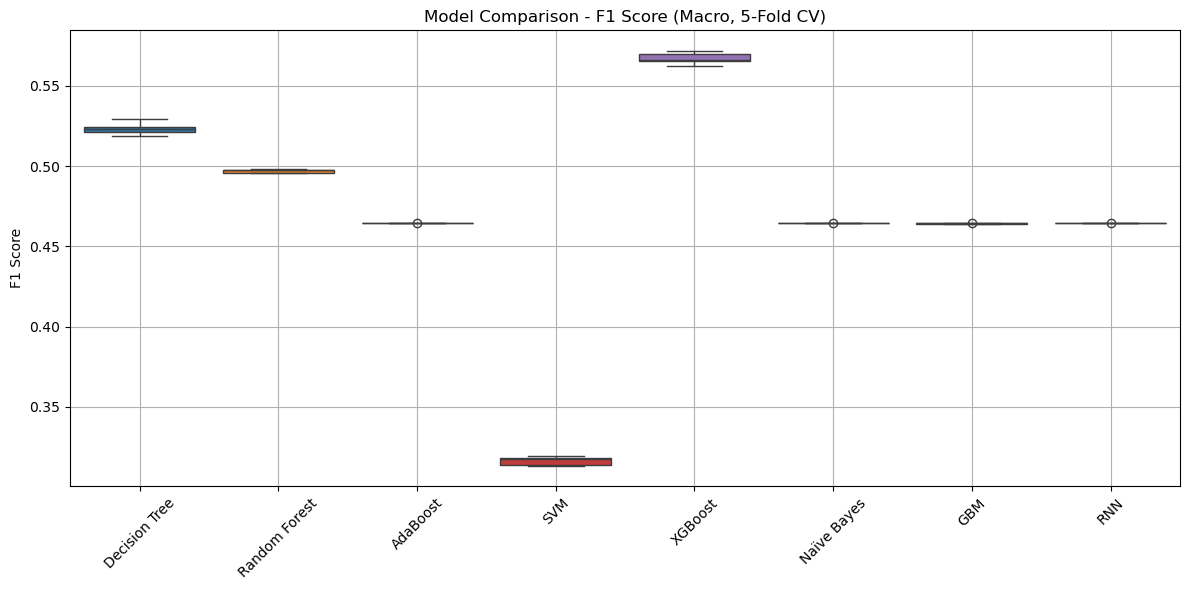


Evaluating models on test set:


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86    114953
           1       0.16      0.17      0.16     18276

    accuracy                           0.76    133229
   macro avg       0.51      0.51      0.51    133229
weighted avg       0.77      0.76      0.76    133229


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93    114953
           1       0.35      0.01      0.03     18276

    accuracy                           0.86    133229
   macro avg       0.61      0.50      0.48    133229
weighted avg       0.79      0.86      0.80    133229


AdaBoost Performance:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93    114953
           1       0.00      0.00      0.00     18276

    accuracy                           0.86    133229
   macro avg    

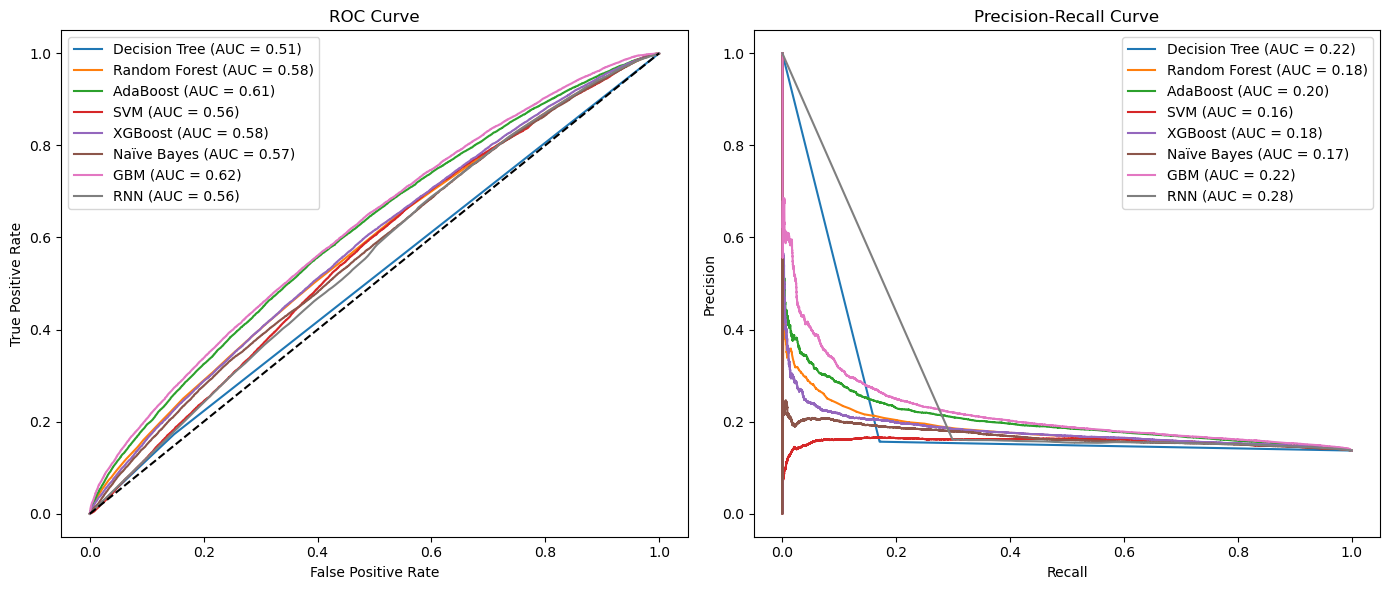


✅ Best model saved: SVM → 'SVM_best_model.pkl'


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# Load and Preprocess Data
# --------------------------

df_train_raw = pd.read_csv("mort_2022-23.csv")
df_test_raw = pd.read_csv("mort_2020_21.csv")

df_train_cleaned, df_train_ml, scaler_svm, scaler_rnn = preprocess_dataset(df_train_raw)
df_test_cleaned, df_test_ml, _, _ = preprocess_dataset(df_test_raw, scaler_svm, scaler_rnn, fit_scalers=False)

X_train = df_train_ml.drop(columns=["target"])
y_train = df_train_ml["target"]

X_test = df_test_ml.drop(columns=["target"])
y_test = df_test_ml["target"]

# Safety check to ensure target is dropped from all feature sets
if "target" in X_train.columns:
    X_train = X_train.drop(columns=["target"])
if "target" in X_test.columns:
    X_test = X_test.drop(columns=["target"])

# Special input for SVM and RNN
X_train_svm = df_train_ml.drop(columns=["target"]).copy()  # ✅ fixed: target removed
X_train_svm["EDAD"] = df_train_ml["EDAD_SVM"]

X_train_rnn = df_train_ml[["EDAD_RNN"]].values
X_test_rnn = df_test_ml[["EDAD_RNN"]].values

# --------------------------
# Class Weights
# --------------------------

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# --------------------------
# Traditional Models
# --------------------------

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                             scale_pos_weight=class_weight_dict[1]),
    "Naïve Bayes": GaussianNB(),
    "GBM": GradientBoostingClassifier(random_state=42)
}

# --------------------------
# Cross-Validation
# --------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='macro')
cv_results = {}

print("Running Cross-Validation...\n")

for name, model in models.items():
    print(f"Training {name}...")
    X_input = X_train_svm if name == "SVM" else X_train
    scores = cross_val_score(model, X_input, y_train, cv=cv, scoring=scorer)
    cv_results[name] = scores
    print(f"{name}: Mean F1 = {scores.mean():.4f} ± {scores.std():.4f}")

# RNN Model
def build_rnn_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = KerasClassifier(
    model=build_rnn_model,
    model__input_dim=X_train_rnn.shape[1],
    epochs=30,
    batch_size=32,
    verbose=0
)
rnn_scores = cross_val_score(rnn_model, X_train_rnn, y_train, cv=cv, scoring=scorer)
cv_results["RNN"] = rnn_scores
print(f"RNN: Mean F1 = {rnn_scores.mean():.4f} ± {rnn_scores.std():.4f}")

# --------------------------
# Test Set Evaluation
# --------------------------

evaluation_results = {}
f1_scores = {}

print("\nEvaluating models on test set:\n")

for name, model in models.items():
    model.fit(X_train_svm if name == "SVM" else X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    prc_prec, prc_rec, _ = precision_recall_curve(y_test, y_proba)
    prc_auc = auc(prc_rec, prc_prec)

    evaluation_results[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec,
        "F1-Score": f1, "ROC AUC": roc_auc, "PR AUC": prc_auc
    }
    f1_scores[name] = f1

    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

# --------------------------
# RNN Final Evaluation
# --------------------------

rnn_final = build_rnn_model(X_train_rnn.shape[1])
rnn_final.fit(X_train_rnn, y_train, epochs=30, batch_size=32, verbose=0)
y_pred_rnn = (rnn_final.predict(X_test_rnn) > 0.5).astype(int).flatten()
y_proba_rnn = rnn_final.predict(X_test_rnn).flatten()

acc = accuracy_score(y_test, y_pred_rnn)
prec = precision_score(y_test, y_pred_rnn, zero_division=0)
rec = recall_score(y_test, y_pred_rnn)
f1 = f1_score(y_test, y_pred_rnn)
roc_auc = roc_auc_score(y_test, y_proba_rnn)
prc_prec, prc_rec, _ = precision_recall_curve(y_test, y_proba_rnn)
prc_auc = auc(prc_rec, prc_prec)

evaluation_results["RNN"] = {
    "Accuracy": acc, "Precision": prec, "Recall": rec,
    "F1-Score": f1, "ROC AUC": roc_auc, "PR AUC": prc_auc
}
f1_scores["RNN"] = f1

print("\nRNN Performance:")
print(classification_report(y_test, y_pred_rnn))

# --------------------------
# ROC & PR Curve
# --------------------------

plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
for name in evaluation_results:
    y_proba = rnn_final.predict(X_test_rnn).flatten() if name == "RNN" else (
        models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba")
        else models[name].decision_function(X_test)
    )
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for name in evaluation_results:
    y_proba = rnn_final.predict(X_test_rnn).flatten() if name == "RNN" else (
        models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba")
        else models[name].decision_function(X_test)
    )
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

# --------------------------
# Step: Custom CKD Scoring Logic
# --------------------------

def ckd_score(metrics, recall_weight=0.8, pr_auc_weight=0.2):
    """
    Custom scoring for CKD risk classification:
    - Emphasizes Recall to minimize false negatives
    - Incorporates PR AUC for imbalanced performance
    """
    return recall_weight * metrics["Recall"] + pr_auc_weight * metrics["PR AUC"]

# Apply scoring to all models
ckd_scores = {name: ckd_score(metrics) for name, metrics in evaluation_results.items()}

# Select model with highest custom score
best_model_name = max(ckd_scores, key=ckd_scores.get)

# --------------------------
# Step: Save Best Model
# --------------------------

if best_model_name != "RNN":
    best_model = models[best_model_name]
    best_model.fit(X_train, y_train)  # Refit just to ensure full training
    joblib.dump(best_model, f"{best_model_name.replace(' ', '_')}_best_model.pkl")
    print(f"\n Best model (CKD custom score) saved: {best_model_name} → '{best_model_name.replace(' ', '_')}_best_model.pkl'")
else:
    rnn_final.save("RNN_best_model.h5")
    print("\n Best model is RNN → 'RNN_best_model.h5'")


3 Explainability Analysis 

In [ ]:

# -------------------------------
# Step 1: Load model and preprocess test set
# -------------------------------

model = joblib.load("SVM_best_model.pkl")

# Reload and preprocess
df_train_raw = pd.read_csv("mort_2022-23.csv")
df_test_raw = pd.read_csv("mort_2020_21.csv")

_, df_train_ml, scaler_svm, scaler_rnn = preprocess_dataset(df_train_raw)
_, df_test_ml, _, _ = preprocess_dataset(df_test_raw, scaler_svm, scaler_rnn, fit_scalers=False)

# Prepare SVM inputs
X_test = df_test_ml.drop(columns=["target"]).copy()
X_test["EDAD"] = df_test_ml["EDAD_SVM"]
y_test = df_test_ml["target"]

# -------------------------------
# Step 2: SHAP with KernelExplainer
# -------------------------------

print("📊 SHAP Summary Plot (KernelExplainer for SVM)")

# Use a small sample for background (to keep KernelExplainer fast)
X_background = shap.utils.sample(X_test, 100, random_state=42)

# Create explainer
explainer_shap = shap.KernelExplainer(model.predict_proba, X_background)
shap_values = explainer_shap.shap_values(X_test, nsamples=100)

# Plot for class 1 (renal-related)
shap.summary_plot(shap_values[1], X_test)

# -------------------------------
# Step 3: LIME Local Explanation
# -------------------------------

print("💬 LIME Explanation for one prediction")

X_lime = X_test.values
feature_names = X_test.columns.tolist()

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_lime,
    feature_names=feature_names,
    class_names=["No Renal", "Renal"],
    mode="classification"
)

# Explain one prediction
idx = 10
exp = lime_explainer.explain_instance(
    data_row=X_lime[idx],
    predict_fn=model.predict_proba,
    num_features=5
)

exp.show_in_notebook()

# -------------------------------
# Step 4: Fidelity, Interpretability, FII
# -------------------------------

fidelity = exp.score
interpretability = len(exp.as_list())
fii = fidelity / (1 + interpretability)

print(f"\n🧠 Fidelity (R²): {fidelity:.4f}")
print(f"📉 Interpretability (features used): {interpretability}")
print(f"📈 Fidelity-Interpretability Index (FII): {fii:.4f}")

# -------------------------------
# Step 5: Plot Metrics
# -------------------------------

plt.figure(figsize=(6, 4))
sns.barplot(x=["Fidelity", "Interpretability", "FII"],
            y=[fidelity, interpretability, fii],
            palette=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title("XAI Evaluation Metrics (LIME)")
plt.tight_layout()
plt.show()


/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_19240/3392776894.py:8: DtypeWarning: Columns (62,69,75,76,83,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_raw = pd.read_csv("mort_2022-23.csv")
/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_19240/3392776894.py:9: DtypeWarning: Columns (13,15,69,76,89,90,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_raw = pd.read_csv("mort_2020_21.csv")


📊 SHAP Summary Plot (KernelExplainer for SVM)


  0%|          | 0/133229 [00:00<?, ?it/s]

4  Interpretability & Visualization

In [ ]:
#(Heatmaps, Decision Paths, Partial Dependence)

In [ ]:
import geopandas as gpd

gdf = gpd.read_file("UDS.gpkg")

# Show structure
print(gdf.columns)
print(gdf.dtypes)
gdf.head()

#EDA

# Plot geometry to visualize the areas
gdf.plot(column=None, figsize=(10, 8), edgecolor="black")
plt.title("Spatial Areas in GeoPack")
plt.show()

# Check missing values
sns.heatmap(gdf.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in GeoDataFrame")
plt.show()

# Histogram for each non-geometry column
for col in gdf.columns:
    if col != "geometry" and pd.api.types.is_numeric_dtype(gdf[col]):
        plt.figure()
        sns.histplot(gdf[col].dropna(), kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()


# Preprocesing

